# NYC Yellow Cab Fare Prediction Model

In this project, I created a neural network that is able to predict the fare of a NYC yellow cab taken in Feburary 2017 using the standard rate code (fare determined by distance, time duration, and surcharges dependent on the time of day).

My process included cleaning the raw dataset (downloaded via http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml) using Pyspark, processing the data and adding synthetic features in pandas, feeding the data into the neural network created in Tensorflow, then testing the model by predicting the fare for four groups (fare >  \$10,  \$10<= fare >  \$30, \$30<= fare >  \$50 and fare >=  \$50) and computing the RMSE and MAE for each case.

The overall RMSE was $4.26 and the MAE was 13.47%

In [1]:
from functions_NN import *
%matplotlib inline 
tf.logging.set_verbosity(tf.logging.ERROR) 

In [2]:
#Upload data from .csv file
df = pd.read_csv("cleaned_reduced_nyc_taxi_data.csv", sep=",")

count    108812.000000
mean      54405.500000
std       31411.463083
min           0.000000
25%       27202.750000
50%       54405.500000
75%       81608.250000
max      108811.000000
Name: Unnamed: 0, dtype: float64
count                  108812
unique                 105860
top       2017-02-10 14:36:30
freq                        4
Name: tpep_pickup_datetime, dtype: object
count    108812.000000
mean          7.233388
std           6.172379
min           0.000000
25%           1.600000
50%           4.770000
75%          11.800000
max          19.990000
Name: trip_distance, dtype: float64
count     108812
unique         2
top            N
freq      107884
Name: store_and_fwd_flag, dtype: object
count    108812.000000
mean        154.605181
std          60.126213
min           1.000000
25%         132.000000
50%         141.000000
75%         211.000000
max         263.000000
Name: PULocationID, dtype: float64
count    108812.000000
mean        147.867294
std          72.399142
min  

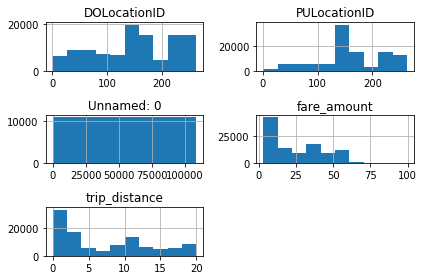

In [3]:
#Take a look at the data before processing
for col in df:
	print(df[col].describe())

df.hist()
plt.tight_layout()

In [4]:
#process dataframe by preparing features and adding synthetic features
df = process_df(df)


count    108812.000000
mean      54405.500000
std       31411.463083
min           0.000000
25%       27202.750000
50%       54405.500000
75%       81608.250000
max      108811.000000
Name: Unnamed: 0, dtype: float64
count    108812.000000
mean          7.233388
std           6.172379
min           0.000000
25%           1.600000
50%           4.770000
75%          11.800000
max          19.990000
Name: trip_distance, dtype: float64
count    108812.000000
mean          0.008528
std           0.091956
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: store_and_fwd_flag, dtype: float64
count    108812.000000
mean        153.605181
std          60.126213
min           0.000000
25%         131.000000
50%         140.000000
75%         210.000000
max         262.000000
Name: PULocationID, dtype: float64
count    108812.000000
mean        146.867294
std          72.399142
min           0.000000
25%          88.000000
50% 

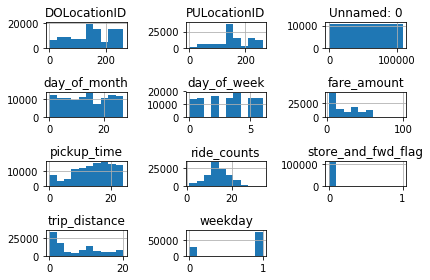

In [5]:
#Take a look at the data after processing
for col in df:
	print(df[col].describe())

df.hist()
plt.tight_layout()

In [6]:
#Set targets and features
targets = df['fare_amount']
features = df.drop(['fare_amount'],1)

X_train, X_val, y_train, y_val = train_test_split(features, targets, test_size=0.2)

Training model...
RMSE (on training data):
  period 00 : 21.42
  period 01 : 12.00
  period 02 : 5.63
  period 03 : 4.55
  period 04 : 4.46
  period 05 : 4.38
  period 06 : 4.34
  period 07 : 4.33
  period 08 : 4.38
  period 09 : 4.28
Model training finished.


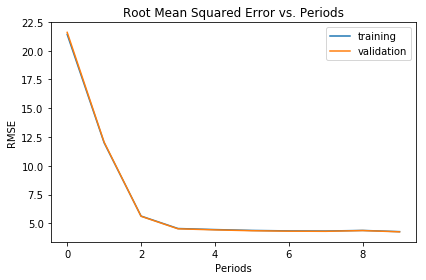

Final RMSE (on training data):   4.28
Final RMSE (on validation data): 4.26


In [7]:
#neural network with adagrad decent
optimizer = train_nn_regression_model(
    my_optimizer=tf.train.AdagradOptimizer(learning_rate=0.01),
 	steps=500,
    batch_size=100,
    hidden_units=[10,10,10,10],
    training_examples=X_train,
    training_targets=y_train,
    validation_examples=X_val,
    validation_targets=y_val,
   )



In [8]:
#Visualize how close predictions are to the targets in each group case

#Split test cases into four groups
test = X_val.join(y_val, how = 'outer')
test = test.drop('Unnamed: 0',1)
test1 = test[test['fare_amount'] < 10]
test2 = test[(test['fare_amount'] >= 10) & (test['fare_amount'] < 30)]
test3 = test[(test['fare_amount'] >= 30) & (test['fare_amount'] < 50)]
test4 = test[test['fare_amount'] >= 50]

In [9]:
#Split features and targets
test1_features = test1.drop('fare_amount',1)
test2_features = test2.drop('fare_amount',1)
test3_features = test3.drop('fare_amount',1)
test4_features = test4.drop('fare_amount',1)

test1_targets = test1['fare_amount']
test2_targets = test2['fare_amount']
test3_targets = test3['fare_amount']
test4_targets = test4['fare_amount']


In [10]:
#Create input functions for predictions
test1_validation_input_fn    = lambda: my_input_fn(test1_features, 
                                                      test1_targets, 
                                                      num_epochs=1, 
                                                      shuffle=False)

test2_validation_input_fn    = lambda: my_input_fn(test2_features, 
                                                      test2_targets, 
                                                      num_epochs=1, 
                                                      shuffle=False)

test3_validation_input_fn    = lambda: my_input_fn(test3_features, 
                                                      test3_targets, 
                                                      num_epochs=1, 
                                                      shuffle=False)

test4_validation_input_fn    = lambda: my_input_fn(test4_features, 
                                                      test4_targets, 
                                                      num_epochs=1, 
                                                      shuffle=False)

In [11]:
#Predict values and calculate rmse for each test case 
test1_predictions = optimizer.predict(input_fn=test1_validation_input_fn)
test1_predictions = np.array([item['predictions'][0] for item in test1_predictions])
test_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(test1_predictions, test1_targets))
print("rmse of rides < 10 dollars is:",test_root_mean_squared_error)

test2_predictions = optimizer.predict(input_fn=test2_validation_input_fn)
test2_predictions = np.array([item['predictions'][0] for item in test2_predictions])
test_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(test2_predictions, test2_targets))
print("rmse of 10 <= rides < 30 dollars is:",test_root_mean_squared_error)

test3_predictions = optimizer.predict(input_fn=test3_validation_input_fn)
test3_predictions = np.array([item['predictions'][0] for item in test3_predictions])
test_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(test3_predictions, test3_targets))
print("rmse of 30 <= rides < 50 dollars is:",test_root_mean_squared_error)

test4_predictions = optimizer.predict(input_fn=test4_validation_input_fn)
test4_predictions = np.array([item['predictions'][0] for item in test4_predictions])
test_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(test4_predictions, test4_targets))
print("rmse of rides >= 50 dollars is:",test_root_mean_squared_error)



rmse of rides < 10 dollars is: 1.544189194236815
rmse of 10 <= rides < 30 dollars is: 2.4660994114495915
rmse of 30 <= rides < 50 dollars is: 4.16366669032216
rmse of rides >= 50 dollars is: 7.876062887600077


In [12]:
#Create dataframe containing both predictions and actual values of test case1 in dollars to visually compare
compare = pd.DataFrame()
compare["actual"]      = test1_targets
compare["predictions"] = test1_predictions
compare['percent_error'] = (compare["predictions"] - compare["actual"])/compare["actual"] * 100
compare['absolute_percent_error'] = abs(compare['percent_error'])

#Calculate overall fitting (+ is overestimate, - is underestimate)
mean_percent_error = compare['percent_error'].mean()
mean_absolute_percent_error = compare['absolute_percent_error'].mean()

print("fitting is:", mean_percent_error,"%")
print("average percent error magnitude is:", mean_absolute_percent_error,"%")
print("\n",compare)

fitting is: 16.844181759381662 %
average percent error magnitude is: 20.652586428414867 %

        actual  predictions  percent_error  absolute_percent_error
25794     9.5     9.156954      -3.611013                3.611013
11822     7.0     6.140943     -12.272249               12.272249
12803     5.5     6.531992      18.763490               18.763490
15275     9.0    10.245729      13.841438               13.841438
19402     7.0     6.696898      -4.330029                4.330029
27979     5.5     7.175227      30.458676               30.458676
21386     7.0     9.030993      29.014179               29.014179
9552      4.5     6.344959      40.999084               40.999084
23039     6.5     7.611694      17.102990               17.102990
17227     5.5     6.762192      22.948941               22.948941
3192      6.0     7.758637      29.310624               29.310624
12006     8.0    11.082875      38.535941               38.535941
21957     5.0     5.209837       4.196739         

In [13]:
#Create dataframe containing both predictions and actual values of test case2 in dollars to visually compare
compare = pd.DataFrame()
compare["actual"]      = test2_targets
compare["predictions"] = test2_predictions
compare['percent_error'] = (compare["predictions"] - compare["actual"])/compare["actual"] * 100
compare['absolute_percent_error'] = abs(compare['percent_error'])

#Calculate overall fitting (+ is overestimate, - is underestimate)
mean_percent_error = compare['percent_error'].mean()
mean_absolute_percent_error = compare['absolute_percent_error'].mean()

print("fitting is:", mean_percent_error,"%")
print("average percent error magnitude is:", mean_absolute_percent_error,"%")
print("\n",compare)

fitting is: -0.9877679587322901 %
average percent error magnitude is: 12.6530184743519 %

        actual  predictions  percent_error  absolute_percent_error
58725    11.0    10.756818      -2.210747                2.210747
57052    10.0     7.566840     -24.331598               24.331598
34077    20.5    14.842680     -27.596683               27.596683
58830    10.5     9.616311      -8.416085                8.416085
36859    10.5     9.580671      -8.755511                8.755511
54676    10.5    10.302528      -1.880682                1.880682
31636    16.0    13.466272     -15.835798               15.835798
54222    14.0     9.824830     -29.822642               29.822642
34919    16.0    15.337029      -4.143566                4.143566
37223    17.0    13.454189     -20.857710               20.857710
45566    13.0    12.988170      -0.091003                0.091003
42842    17.5    18.221769       4.124396                4.124396
52097    17.0    15.362287      -9.633608          

In [14]:
#Create dataframe containing both predictions and actual values of test case3 in dollars to visually compare
compare = pd.DataFrame()
compare["actual"]      = test3_targets
compare["predictions"] = test3_predictions
compare['percent_error'] = (compare["predictions"] - compare["actual"])/compare["actual"] * 100
compare['absolute_percent_error'] = abs(compare['percent_error'])

#Calculate overall fitting (+ is overestimate, - is underestimate)
mean_percent_error = compare['percent_error'].mean()
mean_absolute_percent_error = compare['absolute_percent_error'].mean()

print("fitting is:", mean_percent_error,"%")
print("average percent error magnitude is:", mean_absolute_percent_error,"%")
print("\n",compare)

fitting is: 4.457512584278107 %
average percent error magnitude is: 9.529191127808467 %

        actual  predictions  percent_error  absolute_percent_error
68485    30.5    34.334007      12.570516               12.570516
64790    30.5    30.385254      -0.376217                0.376217
63084    30.0    29.891090      -0.363032                0.363032
65386    32.5    39.534725      21.645308               21.645308
78149    30.0    35.579369      18.597895               18.597895
80250    36.0    36.308777       0.857713                0.857713
75979    48.0    52.097515       8.536490                8.536490
82648    31.5    36.877075      17.070080               17.070080
65082    34.0    41.372871      21.684916               21.684916
84035    45.0    44.439980      -1.244490                1.244490
89091    32.0    33.965012       6.140661                6.140661
75095    40.5    39.846790      -1.612863                1.612863
67839    32.5    28.752626     -11.530380           

In [15]:
#Create dataframe containing both predictions and actual values of test case4 in dollars to visually compare
compare = pd.DataFrame()
compare["actual"]      = test4_targets
compare["predictions"] = test4_predictions
compare['percent_error'] = (compare["predictions"] - compare["actual"])/compare["actual"] * 100
compare['absolute_percent_error'] = abs(compare['percent_error'])

#Calculate overall fitting (+ is overestimate, - is underestimate)
mean_percent_error = compare['percent_error'].mean()
mean_absolute_percent_error = compare['absolute_percent_error'].mean()

print("fitting is:", mean_percent_error,"%")
print("average percent error magnitude is:", mean_absolute_percent_error,"%")
print("\n",compare)


fitting is: -2.6584236644655723 %
average percent error magnitude is: 9.949906417333926 %

         actual  predictions  percent_error  absolute_percent_error
91501     50.0    48.639938      -2.720123                2.720123
99808     56.5    47.190651     -16.476724               16.476724
106283    55.0    58.009651       5.472093                5.472093
108423    53.0    57.628185       8.732425                8.732425
91463     51.0    57.614571      12.969746               12.969746
89783     54.5    54.289757      -0.385767                0.385767
94849     50.5    47.262718      -6.410459                6.410459
101219    52.5    49.461220      -5.788153                5.788153
108468    58.5    57.533676      -1.651836                1.651836
106882    56.0    56.972805       1.737152                1.737152
94941     51.0    43.639542     -14.432271               14.432271
99530     50.5    53.206730       5.359861                5.359861
100555    54.5    52.909462      -2.9

# Conclusion

My model was able to predict fares < \$10 with a \$1.54 RMSE, \$10  <= fare > \$30 with a \$2.47 RMSE, \$30  <= fare > \$50 with a \$4.16 RMSE and fare > \$50 with a \$7.88 RMSE. As the cab fare increases, the RMSE is also expected to increase, not because the model is worse at predicting larger fares, but because RMSE has a direct correlation to the magnitude of the actual fare & prediction.

To get a more proportional value to evaluate how well the model performed in each group, I decided to look at the mean percent error and the mean absolute percent error. From the mean percent error, I was able to extract whether the fit was overestimating or underestimating. It seems for each group the fit was barely overestimating or underestimating, except for fares < \$10, which tended to overestimate the fare by 17% on average. 

To remove the bias, I tried to increase amount of layers and the step size in the neural network. However past a certain point, the increase in complexity was not worth the minimal decrease in bias, which also increased the possibility of creating a model that was overfit. 

When comparing the mean absolute percent error, again it seems all groups performed relatively similar with ≈ 10% error, except  for fares < \$10, the model was worse, having a 21
% error.

I believe the main reason why the model did a better job at predicting fares > \$10 is because of the coarse pickup and dropoff location data. Locations were given as general areas (symbolized as integers) like "upper east side", instead of numerical GPS locations. Because smaller cab fares typically correlate to cab rides with short distances, often times the pickup and dropoff locations would be either in the same location or in a neighboring locations. Although the algorithm still had the trip distance between the locations, it lacked any data to learn any micro-locational nuances along the trip. This did factor into the model's predictions to fares > \$10, however the magnitude of the affect was negligible in comparision to the fare amount. 